<center>
    
# Python User Group
# Tutorial

</center>
<img src="python.jpg" width="100"/> <img src="logo.png" width="150"/>

## Presenter: Neil Malan

# Scaling EAC ROMS analysis in python, from laptop to supercomputer.


 # Introduction

<font size="4">

<img src="ROMS_page.png" />
<br/>

<font size="2">
    
## EAC ROMS model

<br/>

<font size="4">
    
Thanks to Colette Kerry, we have available a large amount of data from a modern regional set up of ROMS for the EAC region. This includes both a 22-year free run, as well as shorter runs with 4D-var data assimilation and higher resolution coastal nests. A subset of data is available at: https://researchdata.edu.au/high-resolution-22-ocean-modelling/1446725

<br/>

I wanted to use this data, but of course being a bit otherwise, I wanted to do it in python, and thus couldn't rely on the previous MATLAB codebase used by Colette, Carlos, Edu etc.

<br/>

The advantage of python, is I'd be able to use more modern tools (Dask, Xarray, xGCM), and be able to work remotely in Jupyter notebook (or Jupyter Lab). The nice things about these tools is that they are scalable, which is nice, as I've up working on the data in 4 different environment, ranging from my laptop to using some of the power of NCI's high performance computing.

## Computing at UNSW

<br/>

This may be obvious to some people who are more embedded in this system, but it took me a while to work out the computing landscape. In order of increasing nerdiness, it boils down to:

<br/>

* Download the sample data onto a local machine. (anyone can do this, no pitfalls)

<br/>

* Work on our local cluster (KATANA), which also hosts the full 22 years of output. Anyone at UNSW can get a Katana account, but you'll need the appropriate permissions from Colette to work with the data. This is good for almost all applications.

<br/>

* Work on the NCI system (where the model is run), which at present also gives you access to all the online heat budget diagnostics (which Colette and I have been working on recently). Here you have the most computing power available, but you do need to be part of an NCI project and be added to Colette's project to have access to all the data - this gets a bit more serious.

<br/>

Whilst the model output is not quite 'big data', I would call it 'large data' and so it's usually best to take your computing to where the data is, rather than trying to transfer data around.


# Outline of tutorial:

<font size="4">
<br>

* I want to have a look at some model output, plot sections, extract timeseries etc.
    * Use xROMS on a local machine (good for messing around and developing code)
    
<br>

* I want to work with the full time series 
    * Use xROMS in an interactive job on Katana
    * If you want to do things requiring grid awareness (vorticity, transports, volume budgets), use xGCM. 

<br>

* I need to use the diagnostic terms
    * Use the Virtual Desktop Infrustructure on NCI, or if you need beast power...
    * Submit a Pangeo job on Gadi (one of the 25th most powerful computers on the planet)


# Packages:

<br>
<br>

## xROMS

https://github.com/bjornaa/xroms

Post-processing tools for ROMS model output, nicely wrapped into Xarray, examples on Github. This package is not unique (see also: https://github.com/powellb/seapy or https://github.com/ESMG/pyroms), but offers the basic functions to work with the data, and gives the benefits of working in Xarray. One limitation is that it doesn't allow the loading of multiple files, but I've added a function to do this (need to get a pull request formalised to add it to the package)

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import xroms
#%matplotlib notebook
%matplotlib inline

In [92]:
 # Initiate the Dataset
A = xroms.roms_dataset("../../ROMS/outer_avg_01491.nc")

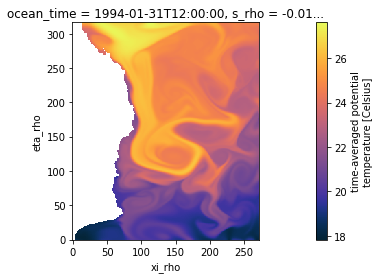

In [93]:
# Plot Sea Surface Temperature
SST = A.temp.isel(ocean_time=0, s_rho=-1)
SST = SST.where(A.mask_rho > 0)

SST.plot(cmap='cmo.thermal')
plt.axis('image');

## We can slice the model at fixed depth levels using the 'zslice' method.

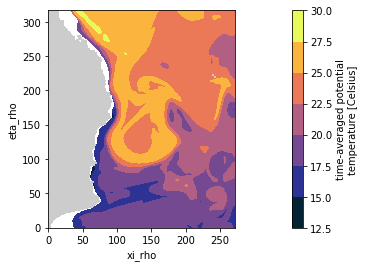

In [94]:
# Temperature at 50 meter at first timeframe
T100 = xroms.zslice(A.temp.sel(ocean_time='1994-02-15T12'), 100)
# Make a contour plot
T100.plot.contourf(cmap='cmo.thermal')
# Plot the land mask
M = A.mask_rho.where(A.mask_rho < 1)
M.plot(add_colorbar=False, cmap='Pastel2_r')
# Make correct aspect ratio
plt.axis('image');

## Plot a geographic map with cartopy

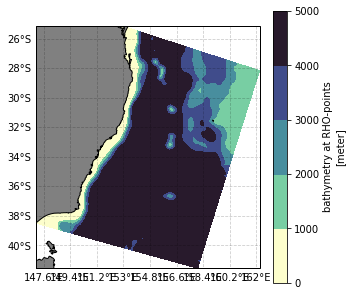

In [97]:
fig = plt.figure(figsize=(5,5))

#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

#plot
ax = plt.axes(projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
A.h.plot.contourf('lon_rho', 'lat_rho', ax=ax, cmap=cmo.deep)

#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

# Take profiles

In [112]:
i, j = 100, 110
Tprofile = A.temp.isel(ocean_time=0, xi_rho=i, eta_rho=j)
Sprofile = A.salt.isel(ocean_time=0, xi_rho=i, eta_rho=j)
depth = -A.z_rho.isel(xi_rho=i, eta_rho=j)

In [113]:
coords={'depth': depth.values}
Tprofile = xr.DataArray(Tprofile, dims=['depth'], coords=coords)
Sprofile = xr.DataArray(Sprofile, dims=['depth'], coords=coords)

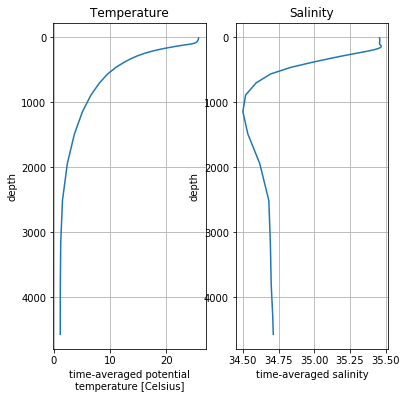

In [116]:
fig, axes = plt.subplots(figsize=(6, 6), ncols=2, sharey=True)
# Use some matplotlib calls for more control
plt.subplot(1,2,1)
Tprofile.plot(y='depth', yincrease=False)
plt.grid(True)
plt.title('Temperature');

plt.subplot(1,2,2)
Sprofile.plot(y='depth', yincrease=False);
plt.grid(True)
plt.title('Salinity');

## Define and plot a section

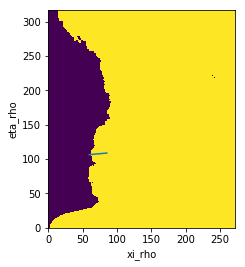

In [98]:
# Define a linear section, draw in map for quick control

lon0, lat0 = 150.8, -34.5
lon1, lat1 = 151.5, -34.6
# Take 50 equidistant points along the section
lon = np.linspace(lon0, lon1, 50)
lat = np.linspace(lat0, lat1, 50)
# Transform to grid coordinates
X, Y = xroms.ll2xy(A, lon, lat)

# Plot
A.mask_rho.plot(add_colorbar=False)
plt.plot(X, Y)
plt.axis('image');

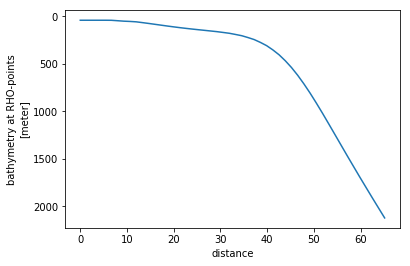

In [99]:
B = xroms.section(A, X, Y)
# Plot depth along section
B.h.plot(yincrease=False);

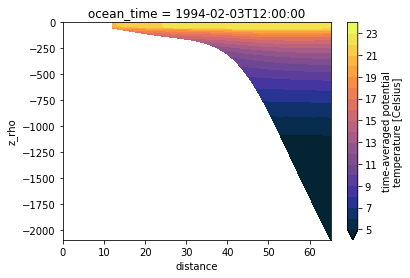

In [100]:
T = B.temp.isel(ocean_time=3)
levels = np.arange(5, 25, 1)
T.plot.contourf('distance', 'z_rho', levels=levels, cmap=cmo.thermal)

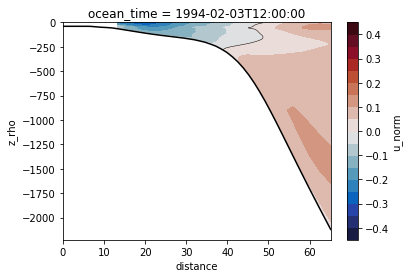

In [101]:
U = B.isel(ocean_time=3).u_norm
levels=np.arange(-0.45, 0.5, 0.05)
U.plot.contourf('distance', 'z_rho', levels=levels, cmap=cmo.balance)
# Add the zero velocity contour
U.plot.contour('distance', 'z_rho', levels=[0], colors='black', linewidths=0.5)
# Add the bottom profile
plt.plot(B.distance, -B.h, color='black');

## We can also look at some metrics and transports for the section

In [104]:
S1 = B.isel(ocean_time=3)     # Fix the time step

# Geometry
length = S1.dS.sum()
print(f"Total length of section    = {float(length)*1e-3:6.2f} km") 
depthmean = (S1.h * S1.dS).sum() / length
print(f"Mean depth                 = {float(depthmean):6.2f} m") 
TotArea = S1.area.sum()
print(f"Total area of section      = {float(TotArea)*1e-6:6.2f} km²") 

# Hydrography
print()
tempmean = (S1.area * S1.temp).sum() / TotArea
print(f"Mean temperature           = {float(tempmean):6.2f} °C")
temp15p = S1.area.where(S1.temp > 15).sum()
print(f"Area with temperature > 15  = {float(temp15p*1e-6):6.2f} km²")

# Flux
print()
flux = (S1.area * S1.u_norm)
netflux = flux.sum()
print(f"Total volume flux          = {float(netflux*1e-6):6.2f} Sv")
outflux = flux.where(S1.u_norm > 0).sum()
print(f"Northwards volume flux     = {float(outflux*1e-6):6.2f} Sv")
influx = flux.where(S1.u_norm < 0).sum()
print(f"Southwards volume flux     = {float(influx*1e-6):6.2f} Sv")
freshflux = flux.where(S1.salt < 34.9).sum()
print(f"Volume flux with S < 34.9  = {float(freshflux*1e-6):6.2f} Sv")


# Add heat flux
rho = 1025        # Sea water density, kg/m³
heat_cap = 4000.0 # Heat capacity, J/(kg K)
Tref = 0.0        # Reference temperature, °C

Tflux = rho * heat_cap * (flux * S1.temp).sum()
Sflux = rho * (flux * S1.salt).sum()
print()
print(f"Heat flux                  = {float(Tflux)*1e-12:6.2f} TW")
print(f"Salt flux                  = {float(Sflux)*1e-9:6.2f} Gg/s")

Total length of section    =  65.14 km
Mean depth                 = 506.51 m
Total area of section      =  33.00 km²

Mean temperature           =  10.63 °C
Area with temperature > 15  =   8.62 km²

Total volume flux          =   1.38 Sv
Northwards volume flux     =   1.92 Sv
Southwards volume flux     =  -0.54 Sv
Volume flux with S < 34.9  =   1.54 Sv

Heat flux                  =  20.57 TW
Salt flux                  =  48.61 Gg/s


# Buuuuuuut... here we are reaching the limits of xROMS, for derived metrics there can be small errors in the way xROMS is slicing and interpolating, and so for more advanced tasks that magnify errors (e.g. fluxes, vorticity calculations), I recommend working on the native c-grid and using xGCM (https://xgcm.readthedocs.io/en/latest/index.html)

notebook credits to https://github.com/vrx-/notebooks/blob/master/xgcm/xgcm_roms.ipynb

## ROMS grid
ROMS uses an Arakawa C-grid. Following xgcm grid topology, rho points are at a center position and u and v points are at inner position in the xi and etha direction repectively.
<font size="4">
<img src="C-grid.png" />
<br/>

## Creating a grid object

While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108

In [85]:
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
    'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
    's':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

## Lazy calculations: vorticity

Using chunks allows to use dask capability using xgcm metrics on xarray. Here an example to calculate vorticity.

In [87]:
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'eta'),  'xi') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'xi'),  'eta') # at psi points (eta_v, xi_u)
ds['dudy'] = grid.diff(ds.u, 'eta')*ds['pn_psi']
ds['dvdx'] = grid.diff(ds.v, 'xi')*ds['pm_psi']
ds['f_psi'] = grid.interp(grid.interp(ds.f, 'eta'),  'xi')

In [88]:
vor = ds['dvdx'] - ds['dudy']
rvor = vor/ds['f_psi'] # normalized vorticity
rvor

<xarray.DataArray (ocean_time: 30, s_rho: 30, eta_v: 316, xi_u: 271)>
dask.array<shape=(30, 30, 316, 271), dtype=float64, chunksize=(1, 30, 316, 271)>
Coordinates:
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_psi     (eta_v, xi_u) float64 dask.array<shape=(316, 271), chunksize=(316, 271)>
    lat_psi     (eta_v, xi_u) float64 dask.array<shape=(316, 271), chunksize=(316, 271)>
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-31T12:00:00 ... 1994-03-01T12:00:00
Dimensions without coordinates: eta_v, xi_u

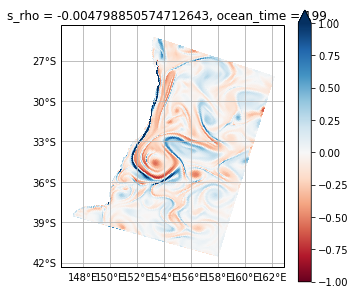

In [89]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
rvor.sel(ocean_time='1994-01-31T12').isel(s_rho=-1).plot(ax=ax, transform=ccrs.PlateCarree(), 
                                        x='lon_psi', y='lat_psi', 
                                        vmin=-1, vmax=1, cmap='RdBu')
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = gl.ylabels_right = False

# Scaling up

The nice thing about these Xarray-based tools, is that they include Dask built in under the hood. This means that we can scale up this code to clusters of 16,32,96 etc. processors on high performance computers, and continue working in our jupyter notebook in exactly the same way as we did on our local machine. Being able to work with the same tools whether using 1Gb or 1Tb of data makes the workflow much, much simpler (for me anyway).

# Setting up ssh tunnels for jupyter notebook
    
## Katana

* You do need to set up your own python environment using conda

* log in to Katana, start an interactive job as follows:

    qsub -I -l select=1:ncpus=2:mem=16gb,walltime=8:00:00

    Then you can use the hostname command to find out what node you are logged into. Now open another bash terminal/Konsole and open a network connection to this node as follows:

    ssh -L 8888:k005:8888 z3289452@katana.restech.unsw.edu.au (if you have issues with connection, you can change the ports used here)

    In the above replace k005 with whatever node was returned by  hostname. ​Now you can start a jupyter lab server as follows:

    jupyter lab --no-browser --ip 0.0.0.0

    The  --no-browser means the browser is not automatically opened and the --ip 0.0.0.0 tells Jupyter to accept connections from any (0.0.0.0) ip address. So now you can just copy paste the Jupyter lab link into your web browser and you'd be running Jupyter lab off Katana on your local machine! No need to do graphics forwarding with x2go and as such there is absolutely no lag! Jupyter lab even has terminals you can open and enter bash commands into, right from your local browser.

## NCI VDI
* assuming that you have all the correct accounts and permissions, there is a handy 'plug and play' script for opening a notebook remotely on VDI - see https://github.com/coecms/nci_scripts - thanks climate folks! They also have one for opening an interactive job on gadi, but I haven't used it.

## Parallelisation

* if you are using xr.open_mfdataset, then you are already enabling dask to run processes in parallel. However if you want to use the power of the Dask graph to profile how your code is running, you can set up a cluster with:

In [105]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Client Scheduler: tcp://127.0.0.1:50062 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Doing big jobs on Gadi

* This requires you to submit an interactive pangeo job, which costs computing hours on whatever project you are registered under, you can then request the amount of processors and RAM you require in the PBS script.

* Really well documented at https://nci-data-training.readthedocs.io/en/latest/_notebook/prep/Setup_Pangeo_environment_Gadi.html so I won't go into it here, as they do it far better than I do!

## Lessons learnt:

* Using modern tools allows you to use the same workflow across different machines and scales
* I remain a huge xarray fan!
* Don't try and reinvent the wheel too much.
* Github is an amazing resource!
* I have a lot to learn about efficient data analysis.

## What are your experiences, use cases? What have I got completely wrong?

* Fire away